__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 10 июн 2024 13:43:13 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_flat.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

8438

,title,address,latitude,longitude,priceM,dt
3537,"квартира-студия, 25,9 м², 5/9 эт.","судак,комплекс апартаментов «бирюзовый квартал» улица айвазовского,д.8",44.851593,34.969177,4.53,2024-06-07
7793,"5-к. квартира, 133,6 м², 13/13 эт.","севастополь,парковая улица ,14б",44.599181,33.460295,22.90,2024-06-10
885,"2-комн. квартира, 55 м², 1/6 этаж","севастополь,р-н гагаринский,мкр.летчики,улица адмирала фадеева,19",44.596716,33.463754,8.80,2024-06-07


In [4]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [5]:
df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
display( len(df_) )
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

108483

85199

,title,address,latitude,longitude,priceM,dt,url
73194,"2-к. квартира, 60,1 м², 3/5 эт.","Севастополь, улица Тараса Шевченко, 49",44.570658,33.460547,11.50,2022-11-15,https://avito.ru/2520814747
44166,"1-к. квартира, 38 м², 1/6 эт.","Севастополь, улица Правды, 33Б",44.575416,33.440137,6.50,2022-09-19,https://avito.ru/2500124540
85696,"3-к. квартира, 70 м², 5/10 эт.","Севастополь, улица Николая Музыки, 38",44.584899,33.519503,9.70,2024-06-05,https://avito.ru/3641103850


In [6]:
df_['dt'].drop_duplicates()

0        2022-08-26
3487     2022-08-29
6945     2022-08-31
10365    2022-09-01
13796    2022-09-02
17315    2022-09-05
20791    2022-09-06
24219    2022-09-07
27334    2022-09-08
30604    2022-09-12
33710    2022-09-13
37123    2022-09-15
40655    2022-09-16
44046    2022-09-19
47601    2022-09-22
51232    2022-09-26
54808    2022-10-08
58407    2022-10-14
61881    2022-11-01
65025    2022-11-04
68169    2022-11-07
71426    2022-11-15
74644    2022-11-28
78240    2023-01-10
81278    2024-06-04
83533    2024-06-05
Name: dt, dtype: object

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

---

In [8]:
df = pd.concat([df,df_])
display( len(df) )
del df_

93637

In [9]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [10]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93637 entries, 0 to 85838
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            93637 non-null  object        
 1   place          93637 non-null  object        
 2   title          93637 non-null  object        
 3   subtitle       3336 non-null   object        
 4   price          93637 non-null  int64         
 5   address        93637 non-null  object        
 6   description    93554 non-null  object        
 7   ts             93637 non-null  datetime64[ns]
 8   nrooms         93637 non-null  int64         
 9   floor          93637 non-null  int64         
 10  nfloors        93637 non-null  int64         
 11  area           93637 non-null  float64       
 12  is_studio      93637 non-null  bool          
 13  is_apartment   93637 non-null  bool          
 14  is_part        93637 non-null  bool          
 15  is_auction     93637 non

In [12]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [13]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

93637

93509

In [14]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

93509

72226

72226

In [15]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
36349,"1-к. квартира, 32 м², 4/10 эт.","Севастополь, улица Тараса Шевченко, 50",44.57,33.46,6.30,2022-09-13,https://avito.ru/2515511791
30455,"2-к. квартира, 60 м², 1/10 эт.","Севастополь, улица Горпищенко, 127 к6",44.59,33.58,6.80,2022-09-08,https://avito.ru/2425784702
58860,"3-к. квартира, 101,7 м², 1/2 эт.","Севастополь, переулок Токарева, 11В",44.58,33.51,12.00,2022-10-14,https://avito.ru/2382361897


---

In [16]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 8, 26)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 10)

In [17]:
gdf_history = gdf.query(f'dt <= @history_date')
gdf = gdf.query(f'dt > @history_date')

In [18]:
display( len(gdf_history) )
display( len(gdf) )

64968

7258

# общая статистика

In [19]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [20]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [21]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].sample(128).explore()

In [22]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf.groupby(['place','nrooms','dt'])['priceM'].describe(percentiles=percentiles)
stat_history = gdf_history.groupby(['place','nrooms','dt'])['priceM'].describe(percentiles=percentiles)

display( stat )
display( stat_history )

count  mean  std  min   1%   5%  10%  25%   50%  \
place      nrooms dt                                                            
sevastopol 1      2024-06-04 660.00  6.89 1.82 2.80 3.91 4.50 4.80 5.50  6.79   
                  2024-06-05 696.00  6.94 1.79 2.90 4.04 4.54 4.80 5.60  6.85   
                  2024-06-07 660.00  7.01 2.01 2.70 3.66 4.50 4.80 5.50  6.85   
                  2024-06-10 655.00  7.05 2.00 2.70 3.60 4.50 4.82 5.60  7.00   
           2      2024-06-04 674.00  9.02 3.02 2.80 4.39 5.65 6.00 6.99  8.75   
                  2024-06-05 659.00  8.99 2.99 2.80 4.38 5.65 6.00 6.95  8.76   
                  2024-06-07 651.00  9.21 3.15 3.50 4.43 5.65 6.00 6.97  8.88   
                  2024-06-10 648.00  9.21 3.11 3.50 4.40 5.65 6.00 6.98  8.80   
           3      2024-06-04 373.00 11.51 5.92 4.30 5.14 6.96 7.50 8.30 10.00   
                  2024-06-05 387.00 11.48 5.82 4.30 5.17 6.85 7.50 8.30 10.00   
                  2024-06-07 347.00 11.61 4.75 4.30 5.25 6.81 7.33 8.50 10.50   
                  2024-06-10 384.00 11.89 6.09 4.30 5.47 7.00 7.50 8.50 10.50   
sudak      1      2024-06-07 121.00  8.73 2.46 3.30 3.54 5.14 5.59 6.10  9.65   
                  2024-06-10 121.00  8.77 2.45 3.30 3.54 5.14 5.59 6.10  9.65   
           2      2024-06-07  83.00 12.36 5.42 3.70 3.86 4.50 5.31 8.40 12.65   
                  2024-06-10  84.00 12.36 5.42 3.70 3.87 4.50 5.37 8.45 12.35   
           3      2024-06-07  27.00 10.05 4.90 3.50 3.53 3.72 4.27 8.00  9.50   
                  2024-06-10  28.00 11.15 6.04 3.50 3.53 3.74 4.49 8.38  9.55   

                               75%   90%   max  
place      nrooms dt                            
sevastopol 1      2024-06-04  7.80  9.25 18.99  
                  2024-06-05  7.90  9.22 18.99  
                  2024-06-07  7.95  9.49 18.99  
                  2024-06-10  7.93  9.28 18.99  
           2      2024-06-04  9.97 12.57 33.00  
                  2024-06-05  9.97 12.50 33.00  
                  2024-06-07 10.39 13.25 33.00  
                  2024-06-10 10.49 13.27 33.00  
           3      2024-06-04 12.90 17.30 85.00  
                  2024-06-05 12.70 17.30 85.00  
                  2024-06-07 13.20 17.50 47.00  
                  2024-06-10 13.31 17.87 85.00  
sudak      1      2024-06-07 10.56 10.84 15.38  
                  2024-06-10 10.56 10.84 15.38  
           2      2024-06-07 15.14 20.75 25.07  
                  2024-06-10 15.10 20.65 25.07  
           3      2024-06-07 11.65 15.00 23.63  
                  2024-06-10 12.85 17.36 30.00

count  mean  std  min   1%   5%  10%  25%  \
place      nrooms dt                                                       
sevastopol 1      2022-08-26 1203.00  6.26 1.91 1.59 2.31 3.70 4.07 5.00   
                  2022-08-29 1191.00  6.25 1.90 1.75 2.73 3.70 4.11 5.00   
                  2022-08-31 1180.00  6.34 1.92 1.30 2.72 3.75 4.20 5.09   
                  2022-09-01 1159.00  6.32 1.89 1.30 2.78 3.75 4.15 5.10   
                  2022-09-02 1204.00  6.33 1.90 1.60 2.80 3.75 4.20 5.10   
...                              ...   ...  ...  ...  ...  ...  ...  ...   
           3      2022-11-04  576.00 11.03 6.01 3.85 5.15 6.47 7.00 8.00   
                  2022-11-07  590.00 11.14 6.15 3.85 4.80 6.30 7.00 8.00   
                  2022-11-15  571.00 11.16 6.25 4.00 4.97 6.35 7.00 7.90   
                  2022-11-28  612.00 11.01 5.73 3.85 4.81 6.30 6.98 8.00   
                  2023-01-10  487.00 10.60 5.96 3.40 5.23 6.28 6.75 8.00   

                               50%   75%   90%    max  
place      nrooms dt                                   
sevastopol 1      2022-08-26  6.00  7.30  8.50  18.50  
                  2022-08-29  6.00  7.21  8.50  18.50  
                  2022-08-31  6.00  7.43  8.76  18.50  
                  2022-09-01  6.00  7.40  8.51  18.50  
                  2022-09-02  6.00  7.40  8.59  18.50  
...                            ...   ...   ...    ...  
           3      2022-11-04  9.60 12.50 15.70 100.00  
                  2022-11-07  9.80 12.50 15.91 100.00  
                  2022-11-15  9.80 12.50 16.30 100.00  
                  2022-11-28 10.00 12.50 16.00 100.00  
                  2023-01-10  8.82 11.75 15.84 100.00  

[72 rows x 12 columns]

In [23]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
sizes = stat.reset_index()['nrooms'].unique()

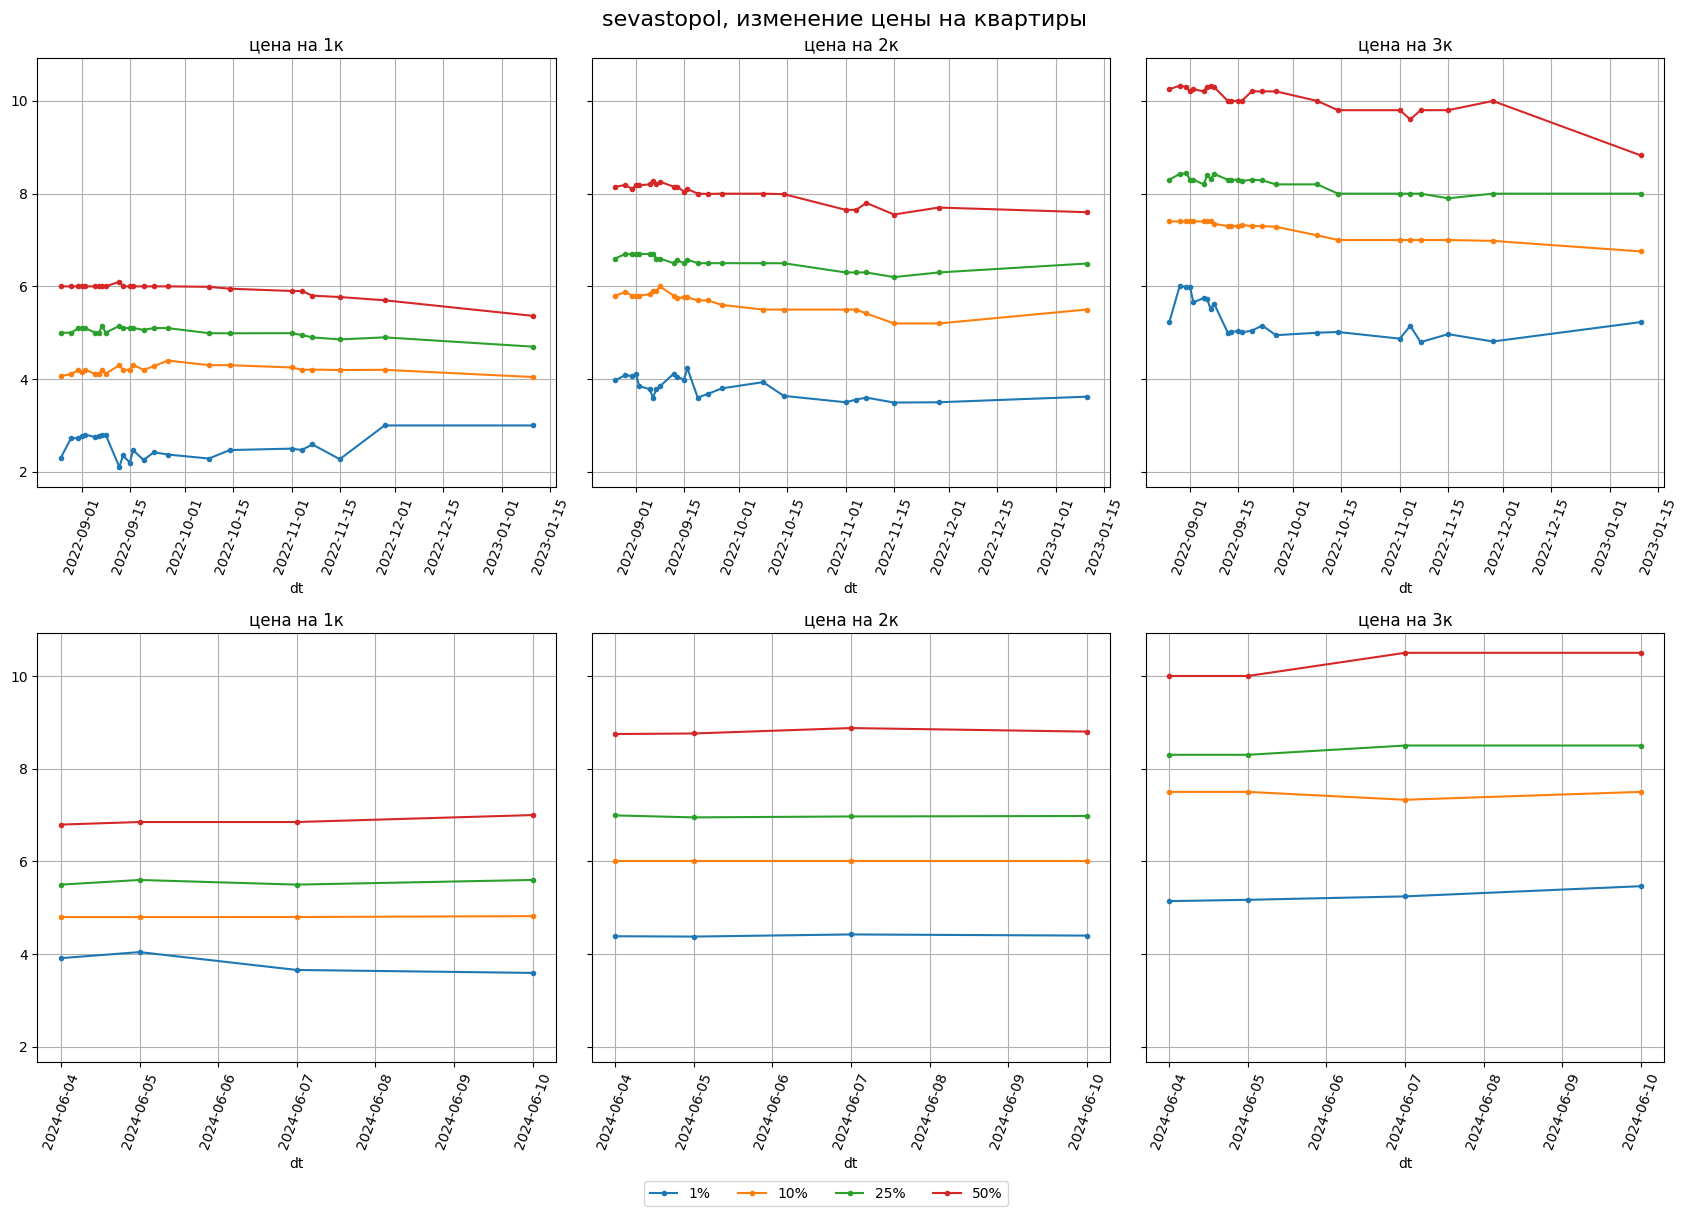

In [24]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )


for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

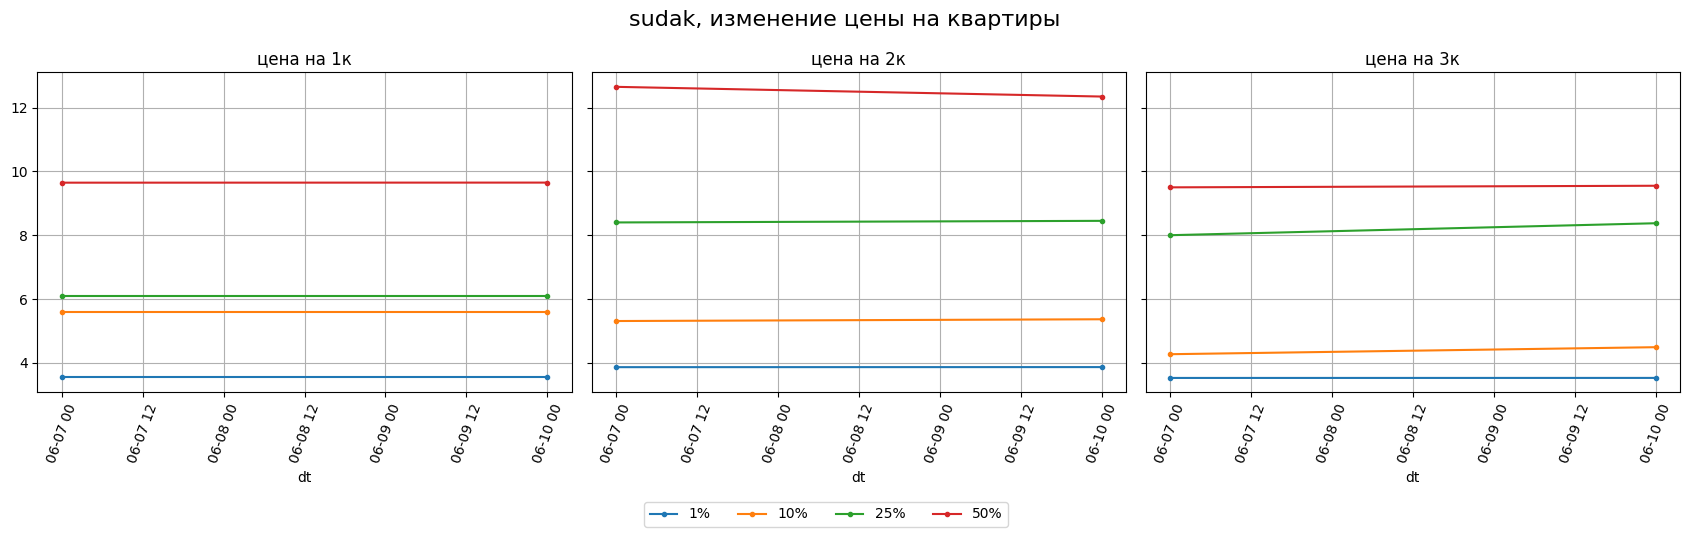

In [25]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=True )
for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [26]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

7258

1920

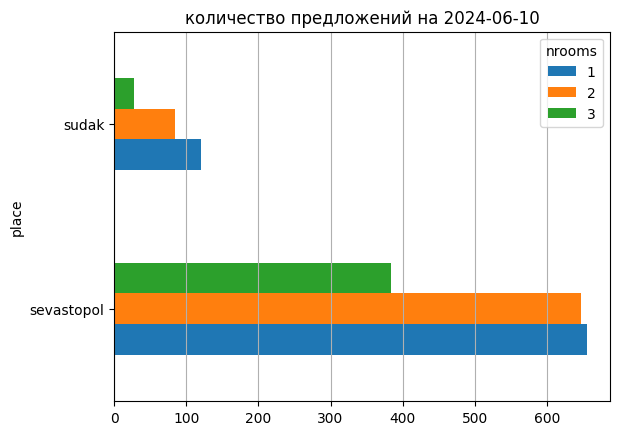

In [27]:
(
gdf_last
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [28]:
(
    gdf_last
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%   50%   75%  \
place      nrooms                                                          
sevastopol 1      655.00  7.05 2.00 2.70 3.60 4.50 4.82 5.60  7.00  7.93   
           2      648.00  9.21 3.11 3.50 4.40 5.65 6.00 6.98  8.80 10.49   
           3      384.00 11.89 6.09 4.30 5.47 7.00 7.50 8.50 10.50 13.31   
sudak      1      121.00  8.77 2.45 3.30 3.54 5.14 5.59 6.10  9.65 10.56   
           2       84.00 12.36 5.42 3.70 3.87 4.50 5.37 8.45 12.35 15.10   
           3       28.00 11.15 6.04 3.50 3.53 3.74 4.49 8.38  9.55 12.85   

                    90%   max  
place      nrooms              
sevastopol 1       9.28 18.99  
           2      13.27 33.00  
           3      17.87 85.00  
sudak      1      10.84 15.38  
           2      20.65 25.07  
           3      17.36 30.00

# цены на карте

In [29]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [30]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [31]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sevastopol.explore()

In [32]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [33]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [34]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [35]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [36]:
frames.explore('area_name', legend=True)

In [37]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
]

In [38]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_ = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_[['title','priceM','address','geometry']].explore( legend=False)

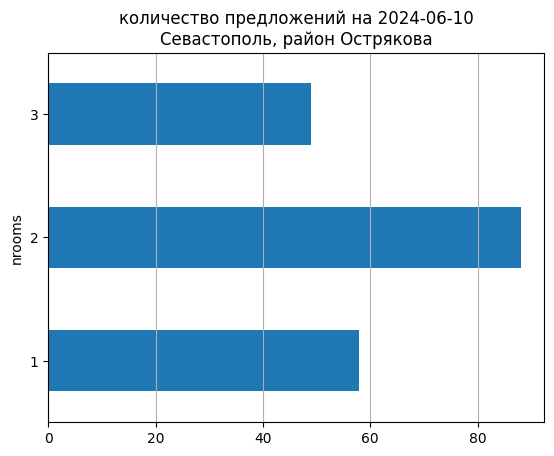

In [39]:
(
    gdf_
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

----

In [40]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 
gdf_local_history = gdf_history.sjoin( frame_, how='inner', predicate='within') 

In [41]:
# stat = gdf_local.groupby(['house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

# sizes = [ '50-70', '70-150', '150-300', ]

In [42]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf_local.groupby(['nrooms','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
stat_history = gdf_local_history.groupby(['nrooms','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

In [43]:
display( stat )
display( stat_history )

count  mean  std  min   1%   5%  10%  25%  50%   75%   90%  \
nrooms dt                                                                       
1      2024-06-04  51.00  5.80 1.14 2.90 3.58 4.60 4.85 5.25 5.50  6.03  7.62   
       2024-06-05  57.00  5.91 1.23 2.90 3.66 4.58 4.79 5.30 5.65  6.40  7.65   
       2024-06-07  55.00  5.92 1.13 2.90 3.63 4.63 4.89 5.35 5.65  6.45  7.56   
       2024-06-10  58.00  5.97 1.13 2.90 3.67 4.66 4.90 5.40 5.75  6.50  7.60   
2      2024-06-04  84.00  8.03 2.64 4.50 4.87 5.81 5.90 6.54 7.38  8.80 10.69   
       2024-06-05  85.00  7.97 2.50 4.95 5.41 5.86 5.90 6.50 7.30  8.60 10.60   
       2024-06-07  76.00  8.03 2.78 4.50 4.84 5.80 5.90 6.24 7.17  8.84 11.00   
       2024-06-10  88.00  8.39 3.11 4.50 5.37 5.90 5.97 6.78 7.65  8.84 11.00   
3      2024-06-04  53.00  9.53 2.01 6.50 6.71 7.22 7.30 8.30 9.15 11.00 12.00   
       2024-06-05  54.00  9.63 2.03 6.50 6.71 7.23 7.36 8.30 9.30 11.18 12.37   
       2024-06-07  50.00  9.63 2.05 6.50 6.70 7.19 7.30 8.30 9.30 11.18 12.41   
       2024-06-10  49.00  9.77 2.12 6.50 6.69 7.12 7.46 8.40 9.30 11.50 12.42   

                    max  
nrooms dt                
1      2024-06-04  9.50  
       2024-06-05  9.50  
       2024-06-07  9.50  
       2024-06-10  9.50  
2      2024-06-04 22.90  
       2024-06-05 22.90  
       2024-06-07 22.90  
       2024-06-10 22.90  
3      2024-06-04 15.50  
       2024-06-05 15.50  
       2024-06-07 15.50  
       2024-06-10 15.50

count  mean  std  min   1%   5%  10%  25%  50%   75%   90%  \
nrooms dt                                                                       
1      2022-08-26  90.00  5.74 1.57 1.85 1.98 3.79 4.10 4.80 5.60  6.80  7.60   
       2022-08-29  96.00  5.75 1.55 1.85 1.99 3.92 4.10 4.89 5.60  6.72  7.57   
       2022-08-31  98.00  5.75 1.40 1.85 2.00 4.04 4.17 4.91 5.63  6.69  7.51   
       2022-09-01  96.00  5.77 1.37 1.85 1.99 3.77 4.20 4.95 5.66  6.80  7.57   
       2022-09-02 107.00  5.72 1.35 1.85 2.02 3.63 4.16 4.97 5.60  6.58  7.50   
...                  ...   ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
3      2022-11-04  79.00  9.65 2.35 6.20 6.43 7.00 7.30 7.95 9.00 11.00 13.18   
       2022-11-07  75.00  9.48 2.32 6.20 6.27 6.90 7.30 7.89 8.70 10.50 12.94   
       2022-11-15  75.00  9.27 2.28 6.10 6.17 6.90 7.00 7.79 8.50 10.34 12.34   
       2022-11-28  85.00  9.60 2.46 6.00 6.25 6.92 7.29 7.75 8.97 10.85 13.10   
       2023-01-10  48.00  9.85 2.60 6.30 6.34 6.50 6.80 7.96 9.70 10.91 13.65   

                    max  
nrooms dt                
1      2022-08-26 12.00  
       2022-08-29 12.00  
       2022-08-31  9.40  
       2022-09-01  9.20  
       2022-09-02  9.20  
...                 ...  
3      2022-11-04 16.70  
       2022-11-07 16.70  
       2022-11-15 16.70  
       2022-11-28 16.70  
       2023-01-10 16.70  

[72 rows x 12 columns]

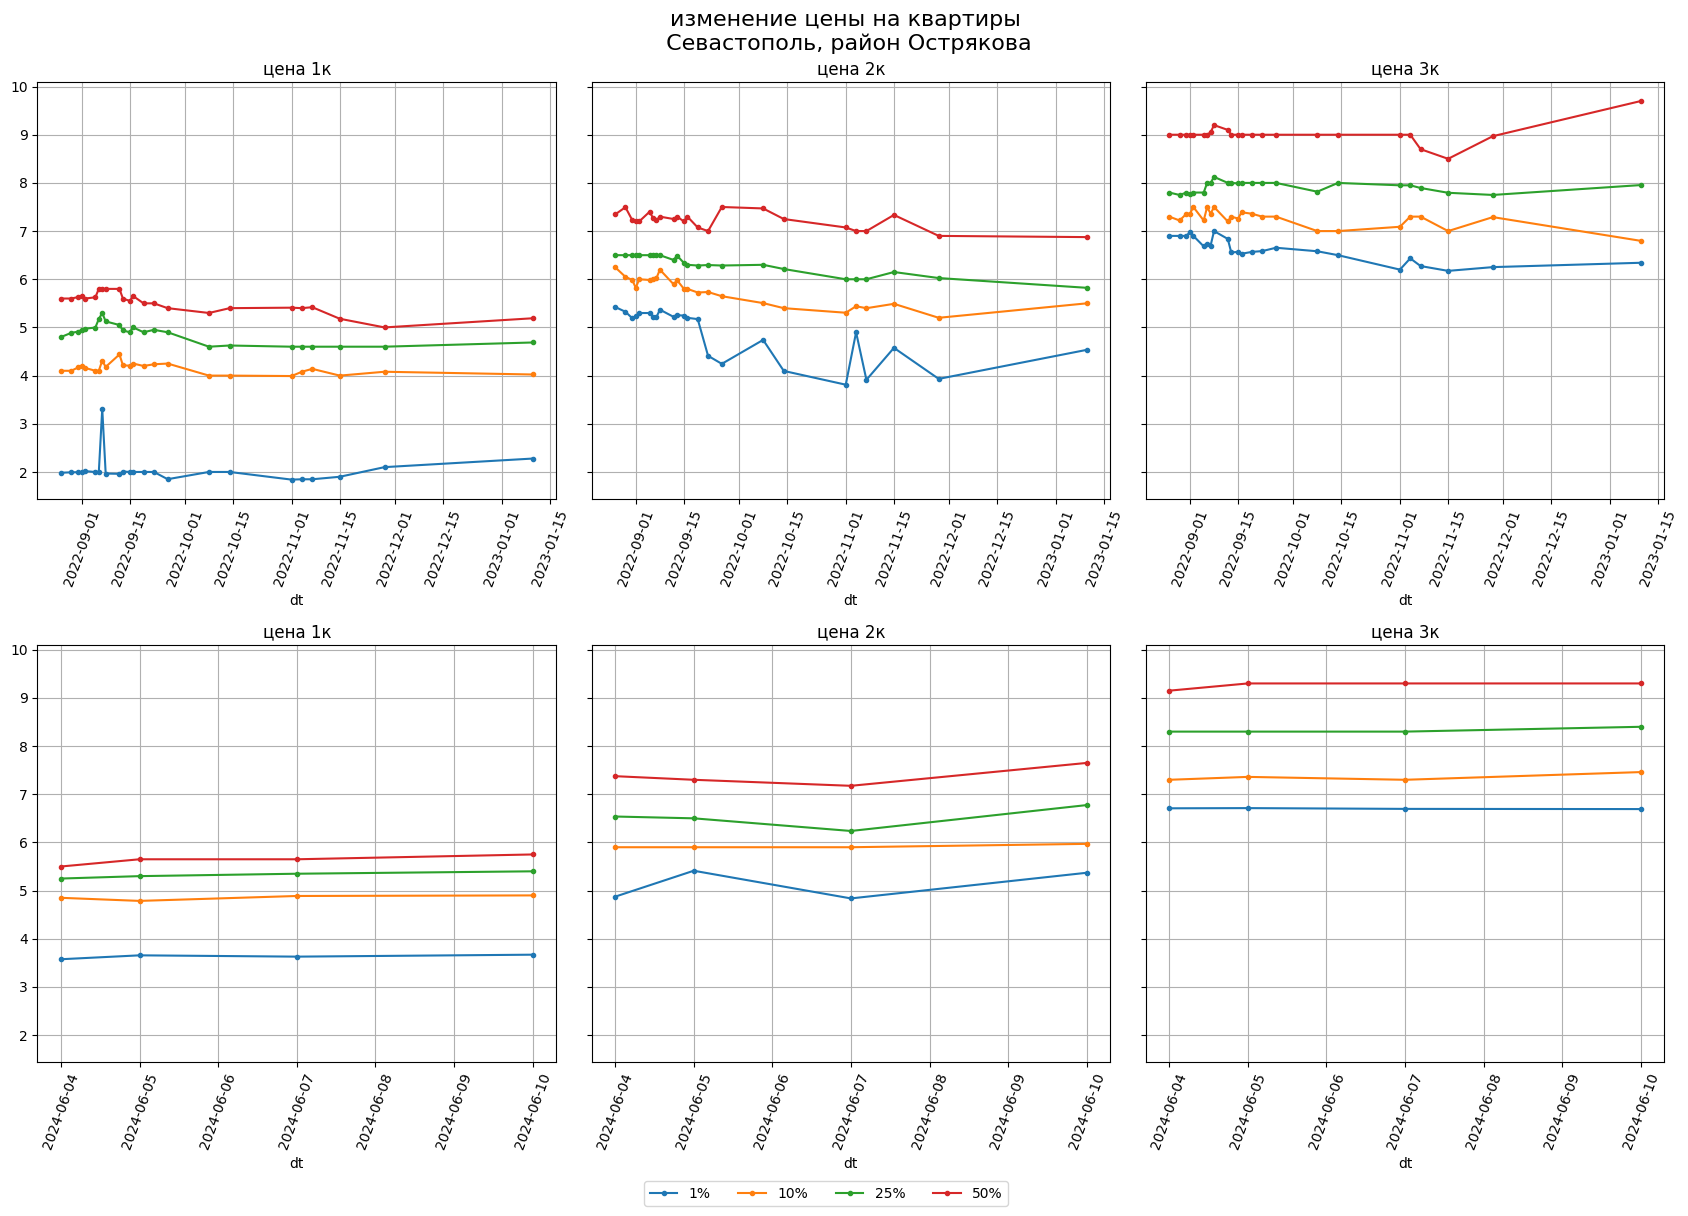

In [44]:
fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()